# Unsupervised outlier detection for Time series data using LSTM + AE
Feature : TMP,HMD,NO2,TVOC,CO2,NH3,PM2.5,PM10 (8 features)   
Time : 2020-10-25 ~ 2021-07-20

## 0. Setting

### 필요한 라이브러리 호출

In [1]:
from glob import glob
import os

import pandas as pd
import numpy as np
import datetime
import time

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False   # 한글 폰트 패치.

import warnings
warnings.filterwarnings('ignore')   # 경고문 처리.

from sklearn.preprocessing import StandardScaler

## 1. Data Load

### 데이터 불러오기 & 전처리

In [2]:
def load_dataset(path):
    feature_list = ['created','temperature','humidity','no2','sgp30_tvoc',
                    'sgp30_co2','nh3','pm_mass_2_5','pm_mass_10']
    new_feature_name = ['time','tmp','hmd', 'no2','tvoc',
                        'co2','nh3','pm_mass_2_5','pm_mass_10']
    
    df = pd.DataFrame(columns = new_feature_name)
    path = path
    flist = sorted(glob(path+'data/*.xlsx'))
    for filename in flist:
        print(filename)
        
        # 원하는 특성만 추출하기
        file = pd.read_excel(filename)
        file = file[feature_list]
        file = pd.DataFrame(file.to_numpy(),columns=new_feature_name)
        
        # 결측치 처리, 실수화
        for col in new_feature_name[1:]:
            file[col] = file[col].astype(str)
            try:
                file[col] = file[col].astype(float)
            except:
                file[col] = file[col].apply(lambda x : np.nan if x[:1] == "'" else x)
                file.fillna(method='bfill', inplace=True)
                file[col] = file[col].astype(float)
        
        # 데이터 병합
        df = pd.merge(df,file,how='outer')
    
    # 시간 순으로 정렬
    df = df.sort_values('time')

    return df
        
        

In [3]:
path = 'C:/Users/dudtj/OneDrive - 숭실대학교 - Soongsil University/Desktop/CL/python/이상치 탐지/'
df = load_dataset(path)
df_data = df.iloc[:,1:]
df_date = df.iloc[:,0]

print(df_data.shape)
print(df_date.shape)
df.head()

C:/Users/dudtj/OneDrive - 숭실대학교 - Soongsil University/Desktop/CL/python/이상치 탐지/data\G1.xlsx
C:/Users/dudtj/OneDrive - 숭실대학교 - Soongsil University/Desktop/CL/python/이상치 탐지/data\G2.xlsx
C:/Users/dudtj/OneDrive - 숭실대학교 - Soongsil University/Desktop/CL/python/이상치 탐지/data\G3.xlsx


KeyboardInterrupt: 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83 entries, 82 to 0
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   time         83 non-null     datetime64[ns]
 1   tmp          83 non-null     float64       
 2   hmd          83 non-null     float64       
 3   no2          83 non-null     float64       
 4   tvoc         83 non-null     float64       
 5   co2          83 non-null     float64       
 6   nh3          83 non-null     float64       
 7   pm_mass_2_5  83 non-null     float64       
 8   pm_mass_10   83 non-null     float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 6.5 KB


In [ ]:
df

,time,tmp,hmd,no2,tvoc,co2,nh3,pm_mass_2_5,pm_mass_10
82,2022-03-23 18:57:00,24.035925,24.821398,1735.0,0.0,400.0,0.606061,5.633601,5.633606
81,2022-03-23 19:07:00,23.939409,24.887470,1729.0,0.0,400.0,1.515152,5.900287,5.900292
80,2022-03-23 19:37:00,23.596245,24.987463,1719.0,0.0,400.0,0.606061,6.233314,6.233319
79,2022-03-23 19:47:00,23.521177,24.998737,1707.0,0.0,400.0,0.909091,5.357161,5.357166
78,2022-03-23 19:57:00,23.467558,25.058374,1719.0,0.0,400.0,0.909091,5.076371,5.076376
...,...,...,...,...,...,...,...,...,...
4,2022-03-24 14:28:00,24.017157,29.833918,1751.0,362.0,400.0,0.303030,4.740204,4.740209
3,2022-03-24 14:38:00,24.148525,29.806650,1779.0,373.0,400.0,1.212121,4.486134,4.486138
2,2022-03-24 14:48:00,24.290617,29.796520,1785.0,361.0,400.0,0.909091,5.037684,5.037689
1,2022-03-24 14:58:00,24.430027,29.784842,1797.0,354.0,400.0,0.909091,5.933449,5.952638


In [ ]:
df.describe()

,tmp,hmd,no2,tvoc,co2,nh3,pm_mass_2_5,pm_mass_10
count,83.000000,83.000000,83.000000,83.000000,83.0,83.000000,83.000000,83.000000
mean,22.116383,27.172409,1752.783133,94.349398,400.0,0.883534,4.749301,4.753365
std,0.946379,1.640342,23.399525,118.171272,0.0,0.410409,0.605812,0.606910
min,21.017153,24.821398,1698.000000,0.000000,400.0,0.000000,3.195365,3.198755
25%,21.316081,25.605041,1735.000000,0.000000,400.0,0.606061,4.364012,4.364016
50%,21.979620,26.878239,1751.000000,34.000000,400.0,0.909091,4.718170,4.718174
75%,22.664608,28.492260,1767.500000,186.500000,400.0,1.212121,5.109113,5.113863
max,24.497051,30.017099,1804.000000,373.000000,400.0,1.818182,6.264382,6.266032


### 표준화 데이터셋 생성

In [ ]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_data)
df_scaled = pd.DataFrame(df_scaled,columns=df_data.columns.to_list())
df_scaled

,tmp,hmd,no2,tvoc,co2,nh3,pm_mass_2_5,pm_mass_10
0,2.040633,-1.441958,-0.764598,-0.803266,0.0,-0.68020,1.468567,1.459183
1,1.938028,-1.401433,-1.022573,-0.803266,0.0,1.54835,1.911456,1.901270
2,1.573216,-1.340104,-1.452530,-0.803266,0.0,-0.68020,2.464516,2.453331
3,1.493413,-1.333189,-1.968478,-0.803266,0.0,0.06265,1.009479,1.000925
4,1.436411,-1.296612,-1.452530,-0.803266,0.0,0.06265,0.543169,0.535458
...,...,...,...,...,...,...,...,...
78,2.020680,1.632396,-0.076667,2.278707,0.0,-1.42305,-0.015106,-0.021809
79,2.160336,1.615672,1.127213,2.372358,0.0,0.80550,-0.437045,-0.442984
80,2.311391,1.609459,1.385187,2.270193,0.0,0.06265,0.478921,0.471326
81,2.459596,1.602296,1.901135,2.210597,0.0,0.06265,1.966528,1.988044


### 최종 데이터셋 : df, df_data, df_date, df_scaled

## 2. Data EDA

<AxesSubplot:title={'center':'Person Correlation of Features'}>

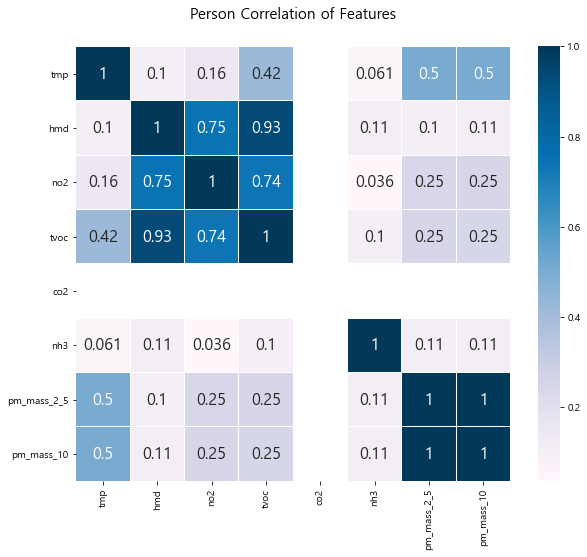

In [ ]:
colormap = plt.cm.PuBu 
plt.figure(figsize=(10, 8)) 
plt.title("Person Correlation of Features", y = 1.05, size = 15) 
sns.heatmap(df_scaled.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
            square = True, cmap = colormap, linecolor = "white", annot = True, 
            annot_kws = {"size" : 16})


tmp &hmd    : 0.63 높은 수치 (온도, 습도) -> 연관성 당연.\n
nh3 &hmd    : 0.64 높은 수치. -> 상관성 존재.

In [ ]:
# 저장
df.to_excel('df.xlsx')

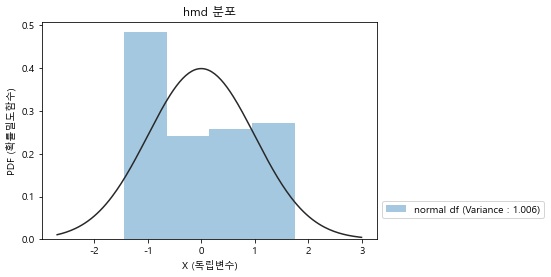

In [ ]:
import scipy as sp
ax = sns.distplot(df_scaled['hmd'], kde=False, fit=sp.stats.norm, 
                  label=f"normal df (Variance :{df_scaled['hmd'].std() : .3f})") 
plt.legend(bbox_to_anchor=(1.0, .2)) 
plt.ylabel('PDF (확률밀도함수)') 
plt.xlabel('X (독립변수)') 
plt.title('hmd 분포')
plt.show()


In [ ]:
def distplot(ax,data,feature):
    ax=sns.distplot(data[feature],kde=False, fit=sp.stats.norm, 
                  label=f"normal df (Variance :{data[feature].std() : .3f})") 
    ax=plt.legend(bbox_to_anchor=(1.0, .2)) 
    ax=plt.ylabel('PDF (확률밀도함수)') 
    ax=plt.xlabel('X (독립변수)') 
    ax=plt.title(feature+' 분포')
    ax=plt.show()

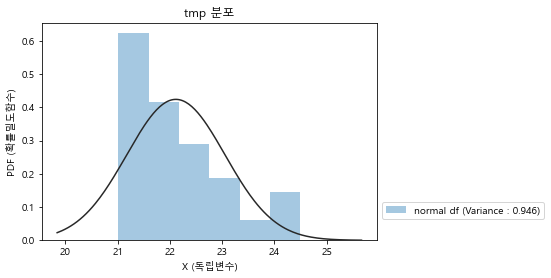

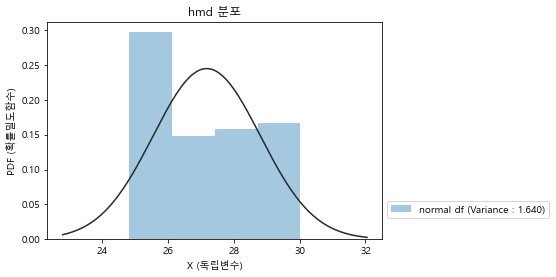

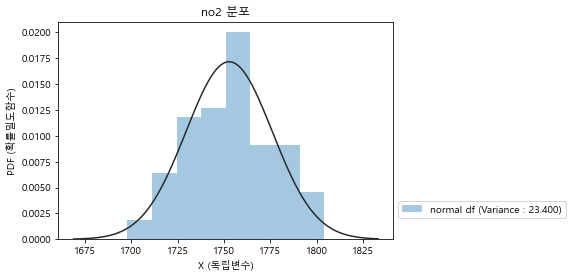

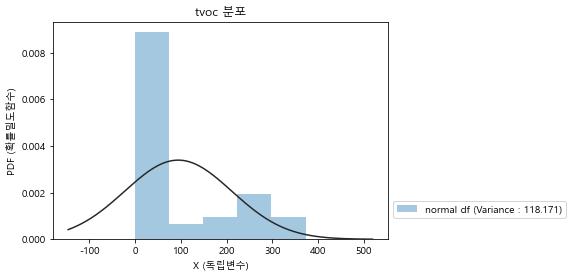

LinAlgError: singular matrix

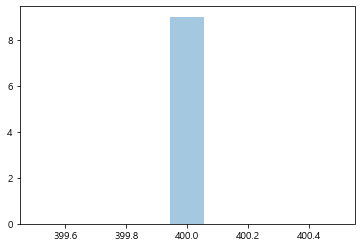

In [ ]:
distplot(ax,df,'tmp')
distplot(ax,df,'hmd')
distplot(ax,df,'no2')
distplot(ax,df,'tvoc')
distplot(ax,df,'co2')
distplot(ax,df,'nh3')
distplot(ax,df,'pm_mass_2_5')
distplot(ax,df,'pm_mass_10')

In [ ]:
df['tmp']

26010    25.767830
26009    25.802683
26008    25.759787
26007    25.746382
26006    25.703487
           ...    
4        32.400547
3        31.700815
2        31.070787
1        30.207516
0        30.161940
Name: tmp, Length: 26011, dtype: float64

In [ ]:
colormap = plt.cm.PuBu 
plt.figure(figsize=(10, 8)) 
plt.title("Person Correlation of Features", y = 1.05, size = 15) 
sns.heatmap(df.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
            square = True, cmap = colormap, linecolor = "white", annot = True, 
            annot_kws = {"size" : 16})

산점도

<AxesSubplot:title={'center':'Person Correlation of Features'}>

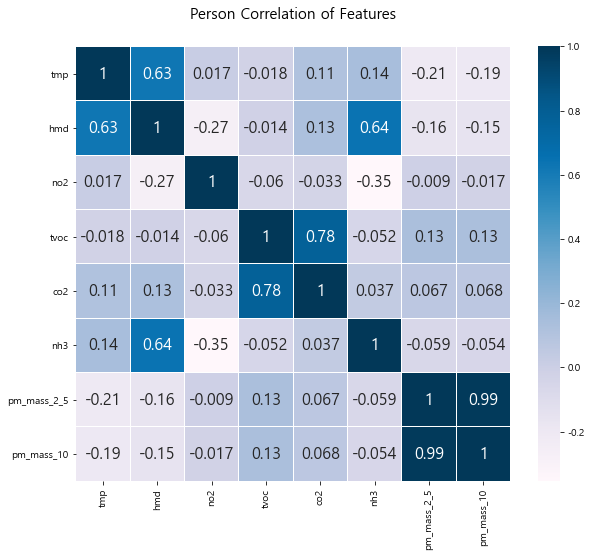

In [ ]:
colormap = plt.cm.PuBu 
plt.figure(figsize=(10, 8)) 
plt.title("Person Correlation of Features", y = 1.05, size = 15) 
sns.heatmap(df_scaled.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
            square = True, cmap = colormap, linecolor = "white", annot = True, 
            annot_kws = {"size" : 16})

에어코리아의 미세먼지 데이터에 대해 LSTM 예측을 진행한 결과는 다음과 같다. 훈련 기간은 2019년, 테스트 기간은 2020년 1월로 입력 변수는 미세먼지, 초미세먼지, 오존, 이산화질소, 일산화탄소, 아황산가스, 타겟 변수는 미세먼지이다.
이를 통해 미세먼지는 초미세먼지 뿐만이 아닌 아황산가스, 일산화탄소 등의 변수 등에도 많은 영향을 받는다는 것을 알 수 있다.

출처 : https://www.bigdata-map.kr/datastory/new/story_10

In [ ]:
def plot_df_scaled(df_scaled, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df_scaled(df_scaled, x=df_scaled['time'], y=df_scaled.tmp, title='tmp'+'시계열 분포')
plot_df_scaled(df_scaled, x=df_scaled['time'], y=df_scaled.hmd, title='hmd'+'시계열 분포')
plot_df_scaled(df_scaled, x=df_scaled['time'], y=df_scaled.no2, title='no2'+'시계열 분포')
plot_df_scaled(df_scaled, x=df_scaled['time'], y=df_scaled.tvoc, title='tvoc'+'시계열 분포')
plot_df_scaled(df_scaled, x=df_scaled['time'], y=df_scaled.nh3, title='nh3'+'시계열 분포')
plot_df_scaled(df_scaled, x=df_scaled['time'], y=df_scaled.pm_mass_2_5, title='pm_mass_2_5'+'시계열 분포')
plot_df_scaled(df_scaled, x=df_scaled['time'], y=df_scaled.pm_mass_10, title='pm_mass_10'+'시계열 분포')

KeyError: 'time'

In [ ]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
for i in range(len(df.columns)):
  plot_df(df, x=df['time'],y=df.columns[i],title=df.columns[i]+'시계열 분포')

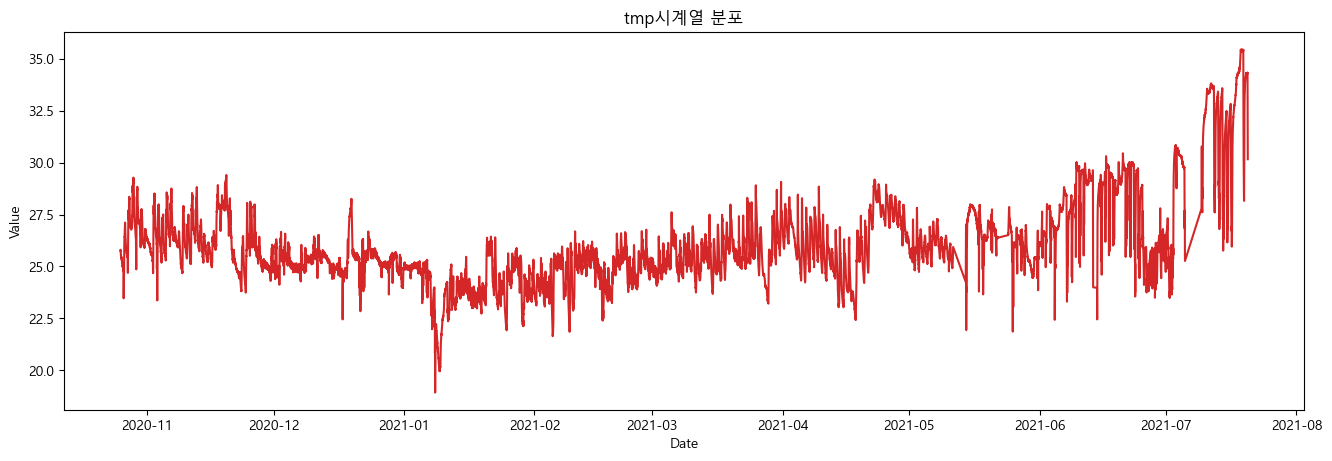

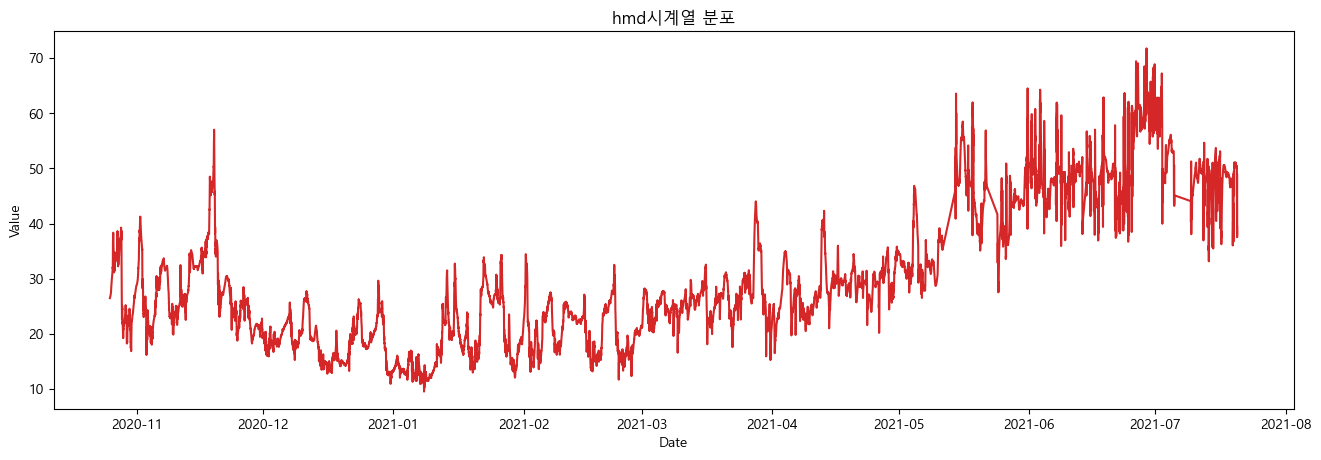

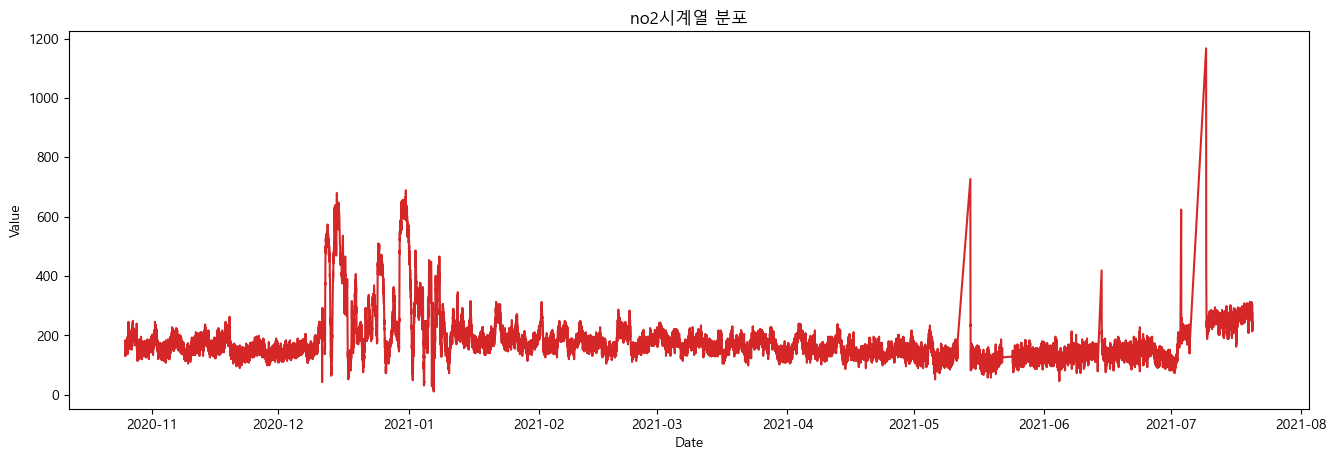

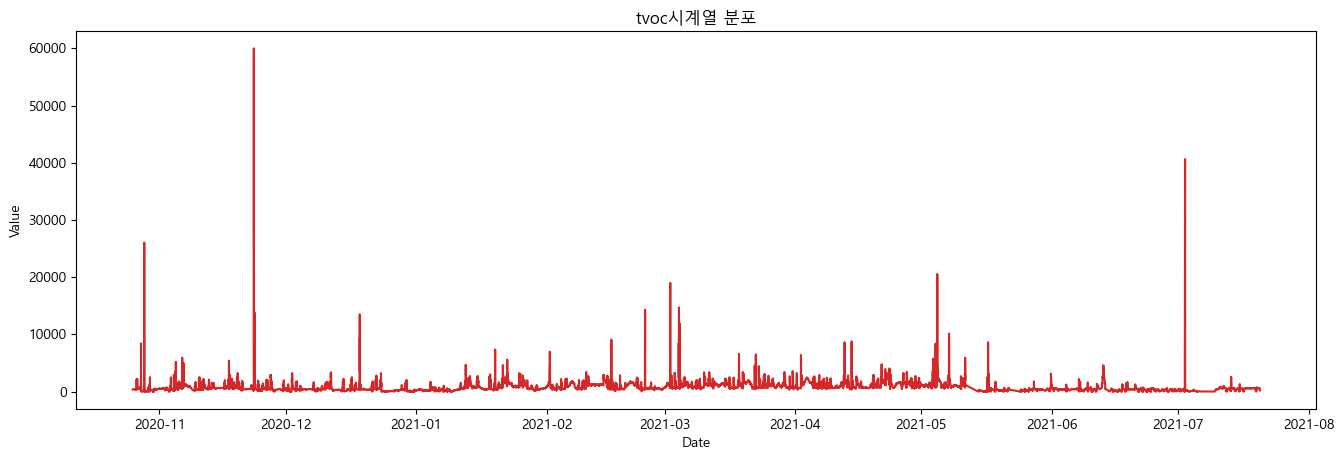

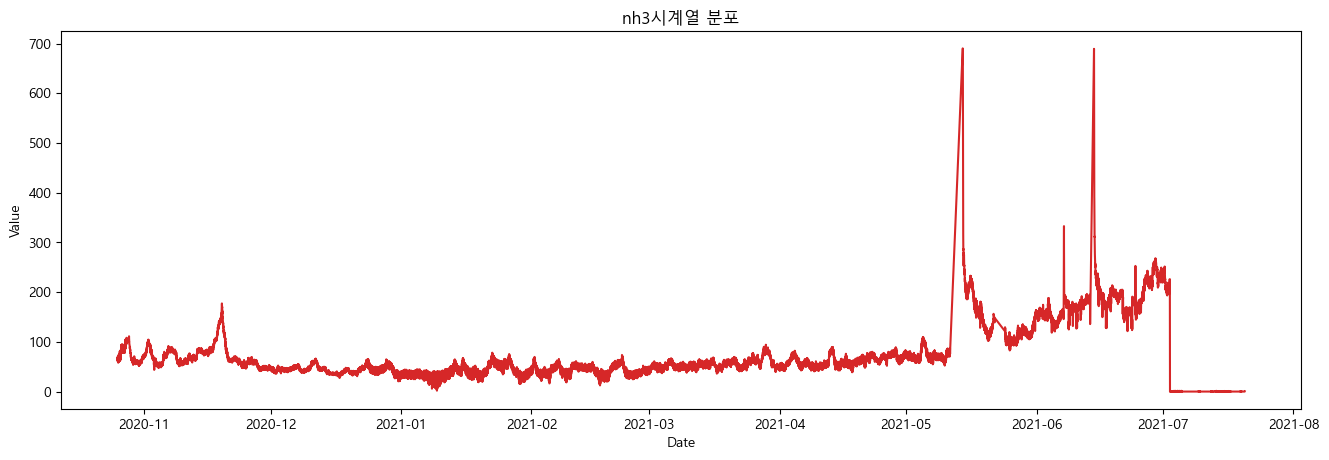

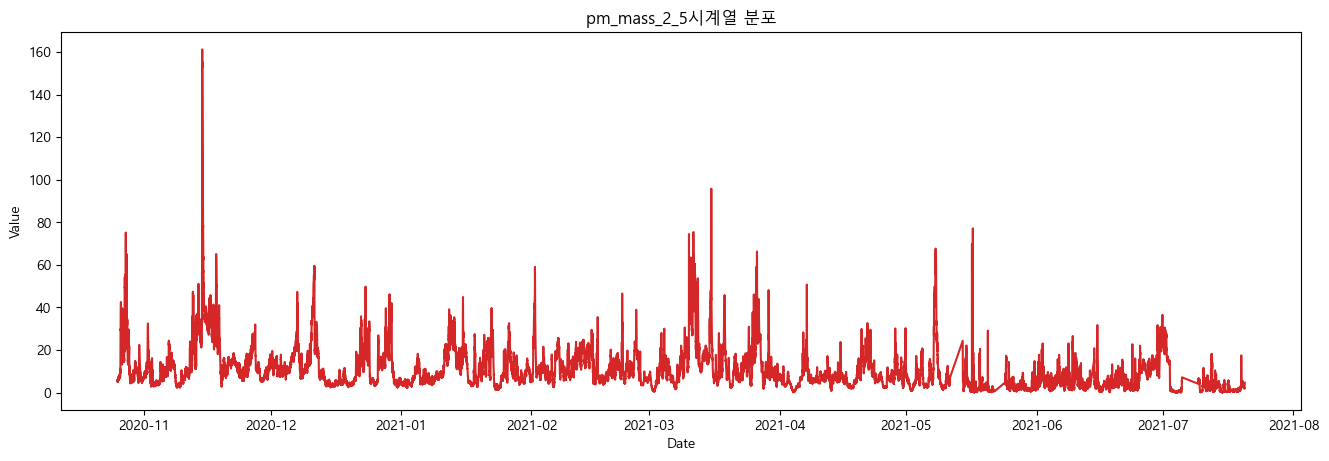

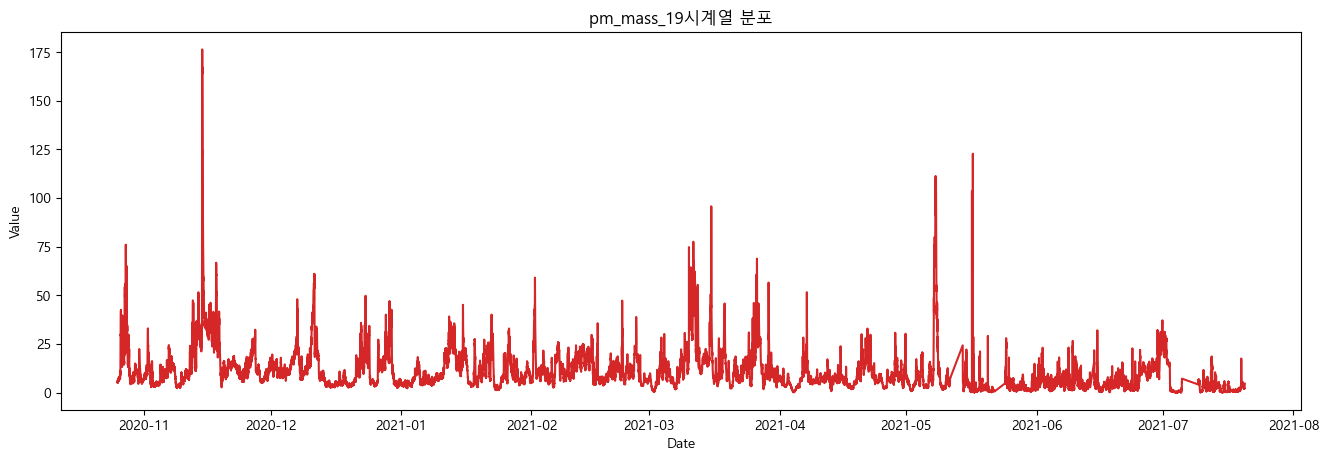

In [ ]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df['time'], y=df.tmp, title='tmp'+'시계열 분포')
plot_df(df, x=df['time'], y=df.hmd, title='hmd'+'시계열 분포')
plot_df(df, x=df['time'], y=df.no2, title='no2'+'시계열 분포')
plot_df(df, x=df['time'], y=df.tvoc, title='tvoc'+'시계열 분포')
plot_df(df, x=df['time'], y=df.nh3, title='nh3'+'시계열 분포')
plot_df(df, x=df['time'], y=df.pm_mass_2_5, title='pm_mass_2_5'+'시계열 분포')
plot_df(df, x=df['time'], y=df.pm_mass_10, title='pm_mass_10'+'시계열 분포')